# Profitable Apps 
For this project we will assume the role of a data analyst for a mobile app development company.
**Our goal is to build an free app that generates revenue by new ad views.**  This implies that the more users who
see the add/install the app, the more revenue we will generate.


This project will involve analyzing available app store data to find predictors of an app being likely to attract
 new users.  Assuming we find good indicators for number of installs, we will attempt to build a predictive model that 
 given early ratings could tell us whether the app is likely to have a lot of installs or not.

## Opening and Exploring the Data
*We will be working with a dataset from 2018 as it was readily available.  It consists or approximately 10k+ apps from 
the Google App markets.  These dataset is available via Kaggle at the below link*
- [Google Play Store Data](https://www.kaggle.com/lava18/google-play-store-apps)


Using this sample of the true dataset should suffice at achieving our goal without making the investment to collect 
a larger dataset.  It is important to note the assumption that the marketplace hasn't changed in the time period in 
following the dataset.  In a production environment this would only serve as a proof of concept and an opportunity
to gain some domain knowledge on feature importance.

**Lets start by opening the data set**

In [187]:
# IMPORTS #
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import jenkspy
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import binarize




google_raw = pd.read_csv(r'RawData/googleplaystore.csv')  # Read the csv file into a pandas Dataframe


One thing to always be conscious of is where your data is coming from.  In our case, the Google Dataset from Kaggle has 
a discussion section and one top discussion involves an inaccuracy in our data.  Apparently the 'Life Made Wi-Fi 
Touchscreen Photo Frame' app has invalid data.  In this case, since it is such a small sample of our data, we will just
remove it.

In [188]:
print(google_raw.loc[[10472]])  # After verifying we have the correct index, drop it using .drop
df = google_raw.drop(google_raw.index[10472])

                                           App Category  Rating Reviews  \
10472  Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0    3.0M   

         Size Installs Type     Price Content Rating     Genres Last Updated  \
10472  1,000+     Free    0  Everyone            NaN  11-Feb-18       1.0.19   

      Current Ver Android Ver  
10472  4.0 and up         NaN  


## Cleaning the Data and Creating Features

Now that we have dropped the advised row of incorrect data, we should spend some time ourselves checking against common
issues associated with unknown datasets.  The first area to check is for duplicate entries in our dataset. Since our
dataset is defined at the app level, we can check this by checking for duplicate application names.

In [189]:
dups = df[df.duplicated(['App'])].App  # Create a DF and then filter to a Series of all Duplicated App Names
sorted(set(dups))[:10]  # Convert to a set to remove duplicates, sort them and print out the first 10 for review

['10 Best Foods for You',
 '1800 Contacts - Lens Store',
 '2017 EMRA Antibiotic Guide',
 '21-Day Meditation Experience',
 '365Scores - Live Scores',
 '420 BZ Budeze Delivery',
 '8 Ball Pool',
 '8fit Workouts & Meal Planner',
 '95Live -SG#1 Live Streaming App',
 'A Manual of Acupuncture']

As we can see, there are quite a few duplicate entries in our dataset.  Now that we see a preview of some examples 
we can take a look at their raw data to see if and where their differences are.

In [190]:
df[df.App == '10 Best Foods for You']  # Lookup the App by Name

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1393,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,17-Feb-17,1.9,2.3.3 and up
1407,10 Best Foods for You,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,17-Feb-17,1.9,2.3.3 and up


In [191]:
df[df.App == 'Instagram']  # Lookup the App by Name

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2545,Instagram,SOCIAL,4.5,66577313,Varies with device,"1,000,000,000+",Free,0,Teen,Social,31-Jul-18,Varies with device,Varies with device
2604,Instagram,SOCIAL,4.5,66577446,Varies with device,"1,000,000,000+",Free,0,Teen,Social,31-Jul-18,Varies with device,Varies with device
2611,Instagram,SOCIAL,4.5,66577313,Varies with device,"1,000,000,000+",Free,0,Teen,Social,31-Jul-18,Varies with device,Varies with device
3909,Instagram,SOCIAL,4.5,66509917,Varies with device,"1,000,000,000+",Free,0,Teen,Social,31-Jul-18,Varies with device,Varies with device


Through some quick investigation it is clear that the area in which there are often differences in the duplicated apps 
is in the total number of reviews given to that app.  There are a few options here, but I believe the most efficient use
 of our time is to go with the App with the highest review count.  
 

In [192]:
df.sort_values(by=['Reviews'], inplace=True, ascending=False)  # Sort rows by highest reviews to lowest
# Remove any duplicate App names, keeping the first occurrence
df.drop_duplicates(subset='App', keep='first', inplace=True)

# Check for dups again to confirm they were removed
dups = df[df.duplicated(['App'])].App
print(sorted(set(dups))[:10])

df[df.App == 'Instagram']  # Verify we removed all dups keeping the highest review count

[]


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2604,Instagram,SOCIAL,4.5,66577446,Varies with device,"1,000,000,000+",Free,0,Teen,Social,31-Jul-18,Varies with device,Varies with device


As we can now see we have removed all duplicate App names from our Google dataset.  We've also displayed the results 
for instagram so that we can check we removed duplicates correctly.

The next step seems to be to start analyzing the data from our slightly cleaned set.  **However, if we keep the goal 
of this project in mind, we will remember that we do not care about paid or Non-English apps.**  Our goal is to make a 
free, english friendly app.  it is important to remove these other apps from our dataset early on so that we do not
consider their values as valid while cleaning and eventually feature engineering.

In [193]:
def is_english(row: pd.DataFrame, met: str, flag: int) -> bool:
    """
    :param row: a row from a pandas dataFrame
    :param met: a column header to determine the column checking
    :param flag: an int provided to serve as the threshold for how many non-ASCII characters are allowed
    :return: a boolean that returns True if it is english
    
    This function uses python's built-in ord function to find out the corresponding number of each character.
    English characters (including punc) are encoded as ASCII standard, meaning each character should fall within 0 and
    127.  However there are instances where english apps use non ASCII characters (emojis, dashes, etc..)  Due to this 
    we will set a threshold for the number of non-ASCII characters the string can have.
    
    TODO: may be worth having the threshold provided systematically based on length of string, etc..
    """
    non_ascii = 0  # Establish counter
    for char in row[met]:  # For each character in the string
        if ord(char) > 127:  # If non-english
            non_ascii += 1  # add 1 to the counter
    
    if non_ascii > flag:  # Post Loop, if counter above threshold, return False
        return False
    else:
        return True
    
df = df[df.apply(is_english, axis=1, met='App', flag=3) == True]  # Apply is_enlgish function row by row on the App col
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2989,GollerCepte Live Score,SPORTS,4.2,9992,31M,"1,000,000+",Free,0,Everyone,Sports,23-May-18,6.5,4.1 and up
4970,Ad Block REMOVER - NEED ROOT,TOOLS,3.3,999,91k,"100,000+",Free,0,Everyone,Tools,17-Dec-13,3.2,2.2 and up
2723,SnipSnap Coupon App,SHOPPING,4.2,9975,18M,"1,000,000+",Free,0,Everyone,Shopping,22-Jan-18,1.4,4.3 and up
3079,US Open Tennis Championships 2018,SPORTS,4.0,9971,33M,"1,000,000+",Free,0,Everyone,Sports,5-Jun-18,7.1,5.0 and up
3229,DreamTrips,TRAVEL_AND_LOCAL,4.7,9971,22M,"500,000+",Free,0,Teen,Travel & Local,6-Aug-18,1.28.1,5.0 and up


Removing price is much simpler, as we have a categorical variable for Free Vs Paid in our dataset.  It is important in 
these situation to check your classifying variables.  So we should look to see if there are cases in which the App is 
labeled as paid, but appears to have no cost.

In [194]:
# Check to ensure there are not invalid cases of this classification variable
invalid = df[(df.Price == '0') & (df.Type == 'Paid')]
print(invalid)

# Double Check that all we have remaining is "Free" apps
df = df[df.Type != 'Paid']
df.Type.unique()

Empty DataFrame
Columns: [App, Category, Rating, Reviews, Size, Installs, Type, Price, Content Rating, Genres, Last Updated, Current Ver, Android Ver]
Index: []


array(['Free', nan], dtype=object)

To make further data exploration easier we will start by exploring the columns and the data types contained
in each column.

In [195]:
def get_cat(series: pd.Series, empty_flag: bool) -> str:
    """
    :param series: a pandas series of data (should be of one data type)
    :param empty_flag: a boolean to call out an empty column (containing all NaNs)
    :return: a string that is the 'category of the datatype'
    
    This function will take a given series and return a generalized category for the datatype.
    This is necessary for readability as df.dtypes will return ungrouped types (i.e. float64, int64)
    as well as return some options that do not provide much insight (i.e. object)
    """
    if empty_flag:  # Catch Empty Columns
        return 'Empty'
    elif pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif pd.api.types.is_bool_dtype(series):
        return 'Boolean'
    elif pd.api.types.is_categorical_dtype(series):
        return 'Categorical'
    elif pd.api.types.is_string_dtype(series):
        return 'Text'
    else:  # Catches all others for review
        return 'Unknown'


def col_categories(data: pd.DataFrame):
    """
    :param data: a pandas Dataframe consisting of columns of data you want to explore their categories
    :return: None
    Prints the column name and data type of each column in the dataframe 
    """
    if data.dropna().empty:  # Catches Error
        raise ValueError('DataFrame Provided Contains is either empty or only contains NaNs') 
        # sys.exit(1)
    for col in data.columns:  # For Each Column
        if data[col].dropna().empty:  # Catch Empty Columns
            empty = True  # Set Flag
        else:
            empty = False  # Set Flag
        print(col, ': ', get_cat(data[col], empty))  # Print and Call Column Categories

In [196]:
# Call col_categories to get an understanding of our Datasets 
print('Google Data')
col_categories(df)


Google Data
App :  Text
Category :  Text
Rating :  Numerical
Reviews :  Text
Size :  Text
Installs :  Text
Type :  Text
Price :  Text
Content Rating :  Text
Genres :  Text
Last Updated :  Text
Current Ver :  Text
Android Ver :  Text


Now that we have cleaned up our dataset a little, we can seem some areas where we may be suspicious of the data type 
returned to us.  For example, "Category" in the Google data could potentially be converted into a categorical variables. 
While making these conversions may not be the most crucial step we will do here today, it serves as a good step to 
ensure later on you can grab data by type. Even for metrics we may not end up using, it is reasonable to do some basic 
level of cleaning and converting so that this data can be exported and saved for future uses (which may need the other 
features)

**The first step is to confirm our assumptions on data types by looking at samples of the data.**

In [197]:
# Look at the first few rows of our data
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2989,GollerCepte Live Score,SPORTS,4.2,9992,31M,"1,000,000+",Free,0,Everyone,Sports,23-May-18,6.5,4.1 and up
4970,Ad Block REMOVER - NEED ROOT,TOOLS,3.3,999,91k,"100,000+",Free,0,Everyone,Tools,17-Dec-13,3.2,2.2 and up
2723,SnipSnap Coupon App,SHOPPING,4.2,9975,18M,"1,000,000+",Free,0,Everyone,Shopping,22-Jan-18,1.4,4.3 and up
3079,US Open Tennis Championships 2018,SPORTS,4.0,9971,33M,"1,000,000+",Free,0,Everyone,Sports,5-Jun-18,7.1,5.0 and up
3229,DreamTrips,TRAVEL_AND_LOCAL,4.7,9971,22M,"500,000+",Free,0,Teen,Travel & Local,6-Aug-18,1.28.1,5.0 and up


*The user should be looking at more than the first 5 rows of data to get a good understanding of the data, this 
amount is just used for readability*

### As we expected, we have a few areas worth converting/cleaning:
- **Category**
    - From Text to Category
- **Size** - Seems like there are 2 Options 
    - Try converting to a numerical and impute the "Varies By Size"
    - Explore the distribution of this metric to see if we can create ranges and thus categories
- **Installs**
    - From Text to Categorical
- **Type**
    - From Text to Categorical
- **Content Rating**
    - From Text to Categorical
- **Genre**
    - Multiple Entry Text, split on ; - Will probably be worth to dummify the variable to turn them into multiple binary
    variables
- **Last Updated**
    - From Text to Date

*Current Version and Android Version Required are not something I will be working with as I think those categories are 
more complicated in their feature engineering, and we want to prioritize our time in the most effective way.*

In [198]:
# Simple Text to Categorical Conversion
df['Category'] = pd.Categorical(df.Category)
df['Installs'] = pd.Categorical(df.Installs)
df['Type'] = pd.Categorical(df.Type)
df['Content Rating'] = pd.Categorical(df['Content Rating'])

#  Recall our Original Col DataType Function
print('Google Data')
col_categories(df)

Google Data
App :  Text
Category :  Categorical
Rating :  Numerical
Reviews :  Text
Size :  Text
Installs :  Categorical
Type :  Categorical
Price :  Text
Content Rating :  Categorical
Genres :  Text
Last Updated :  Text
Current Ver :  Text
Android Ver :  Text


Now that we have completed the one step conversion of data types, we can move onto the more complicated.  We will 
start by analyzing the Size Category.  I believe the best process will be to first analyze the data we have for google.

By examining the data in the CSV file we can see they have a standard data structure format. We can use regular 
expressions to analyze this more.

In [199]:
def patt_out(row: pd.DataFrame, met:str, patt:str, result:list):
    """
    :param row: row supplied by the apply function
    :param met: the column of interest from the row
    :param patt: Regex pattern that is the standard format
    :param result: a list to append to all of the non-standard format responses for investigation
    :return: None
    
    This function serves to find those values from a given row/column that do not fit a regex format supplied.
    This can be used to ensure we are not missing some odd values during out data cleaning.
    
    TODO: Convert to a bigData Approach using Pyspark for scalability 
    """
    pattern = re.compile(patt)
    if not pattern.match(row[met]):
        result.append(row.Size)
    return None


mismatch = list()  # Initiate a list to contain results
regexp = '(\d+(?:\.\d+)?([Mk])$)'  # Looks for any int or float
# Applies the pattern outlier function row by row
df.apply(patt_out, axis=1, met='Size', patt=regexp, result = mismatch)
mismatch = set(mismatch)  # Removes Duplicates by Converting to a Set
mismatch

{'Varies with device'}

**As you can see through our investigation of our data format for the Size column, everything follows the pattern:**
- A Numeric Followed by 'M' for megabyte or 'k' for kilobyte
- A Categorical Variable of 'Varies with device'

Now to really get this feature into a category datatype we have to convert those with k or M to their corresponding 
number of bytes (shared unit).

In [200]:
def convert_bytes(val:str) -> float:
    """
    :param val: Values from a Series containing either a 'M' or 'k' to signify the unit of bytes
    :return: converted to bytes value as a float
    
    This function serves to determine the byte units implied by the string and convert to raw kilobytes for comparison
    """
    if val == 'Varies with device':
        return 0.0
    if val[-1] == 'M':
        return float(val[:-1]) * 1000  # Multiply by 1000 to convert to kb
    if val[-1] == 'k':
        return float(val[:-1])

sizes = df[df.Size != 'Varies with device'].Size  # Creates a series of all sizes we have data on
sizes = sizes.apply(convert_bytes)  # Converts the sizes to the same unit, kilobytes

sizes.describe()  # View General Descriptive Statistics

count      7708.000000
mean      20523.375000
std       21809.168961
min           8.500000
25%        4700.000000
50%       12000.000000
75%       28000.000000
max      100000.000000
Name: Size, dtype: float64

Now that we can see some basic descriptive statistics from this metric, we can start to gain insight on how we 
should categorize this variable.  Of interest we can see the average size is approx. 20,000 kb for our apps, however 
the variance in this metric is very high as well with a standard deviation of almost 22,000 kb.  Due to this I find it 
may be valuable to get a better look at the distribution of this metric.

Text(0.5, 1.0, 'Google App Size Distribution')

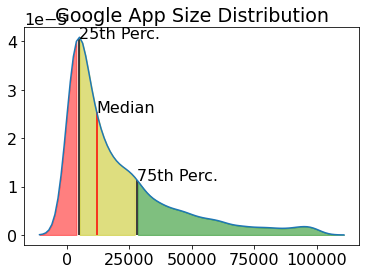

In [201]:
ax = sns.kdeplot(sizes, shade=False, legend=None)  # Create a Subplot to get the Kernel Density Estimation Plot
lines = ax.get_lines()[0]  # Grab the lin objects from the kde
x, y = lines.get_data()  # convert line into x & y coords

# Color fill the visual based on percentile - Default Interpolation
ax.fill_between(x, y, where = x <= np.percentile(sizes, 25), color='r', alpha=0.5)
ax.fill_between(x, y, where = (x > np.percentile(sizes, 25)) & 
                              (x < np.percentile(sizes, 75)), color='y', alpha=0.5)
ax.fill_between(x, y, where = x >= np.percentile(sizes, 75), color='g', alpha=0.5)

# Add vertical lines to signify the percentiles we shaded by
ax.vlines(x = np.percentile(sizes, 25), ymin=0, ymax=np.interp(np.percentile(sizes, 25), x, y))
ax.vlines(x = np.percentile(sizes, 75), ymin=0, ymax=np.interp(np.percentile(sizes, 75), x, y))
ax.vlines(x = np.percentile(sizes, 50), ymin=0, ymax=np.interp(np.percentile(sizes, 50), x, y), color='r')

#Add Data Labels for our lines to avoid confusion
ax.text(np.percentile(sizes, 25), np.interp(np.percentile(sizes, 25), x, y), '25th Perc.')
ax.text(np.percentile(sizes, 50), np.interp(np.percentile(sizes, 50), x, y), 'Median')
ax.text(np.percentile(sizes, 75), np.interp(np.percentile(sizes, 75), x, y), '75th Perc.')

ax.set_title('Google App Size Distribution')  # Add a title

As we can see in the above Kernel Density Plot (used as an approximation of the PDF) the size data is heavily skewed to 
left and smaller apps.  This will mean that there is much more variation in the upper percentiles when it comes to App 
size.  There are two main ways people tend to lean when presented with this type of situation.  
- That you have so many apps clustered together on the small side that we need additional categories on that side to 
see the true nuance.
- Since there is so much variance (large spread) at the top percentiles we will want to have extra categories on that 
side of the distribution to account for different behavior.

In cases like these I always find it beneficial to apply Fisher-Jenks algorithm first to help confirm the insight 
we've gained from our early analysis.  While this algorithm will find the natural breaking points for us in the data, 
we want to evaluate the distribution both with and without outliers.

In [202]:
#Inner Quartile Range
IQR = (np.percentile(sizes, 75) - np.percentile(sizes, 25))  # Establish the Inner Quartile Range
upper_bound = np.percentile(sizes, 50) + (IQR * 1.5)
lower_bound = np.percentile(sizes, 50) - (IQR * 1.5)

sizes_trim = sizes[(sizes >= lower_bound) & (sizes <= upper_bound)]  # Trim off sizes outside our range

# Print Results of each Percentile
print(os.linesep, 'Outliers Not Removed')
for i in range(0, 9):
    print ((i + 1)*10, 'Percentile', np.percentile(sizes, (i +1)*10))

# Establish the natural breaking points using Fisher-Jenks
breaks = jenkspy.jenks_breaks(sizes, nb_class=5)
print(os.linesep, 'FJ breaks', breaks)  # Print the Break Points

# Print percentiles with outliers removed
print(os.linesep, 'Outliers Removed')
for i in range(0, 9):
    print ((i + 1)*10, 'Percentile', np.percentile(sizes_trim, (i +1)*10))

# Establish and print breaks using fisher-jenks algo with outliers removed 
breaks = jenkspy.jenks_breaks(sizes_trim, nb_class=5)
print(os.linesep, 'FJ breaks', breaks)



 Outliers Not Removed
10 Percentile 2500.0
20 Percentile 3900.0
30 Percentile 5800.0
40 Percentile 8500.0
50 Percentile 12000.0
60 Percentile 17000.0
70 Percentile 25000.0
80 Percentile 34000.0
90 Percentile 52000.0

 FJ breaks [8.5, 10000.0, 23000.0, 42000.0, 69000.0, 100000.0]

 Outliers Removed
10 Percentile 2300.0
20 Percentile 3500.0
30 Percentile 5000.0
40 Percentile 7100.0
50 Percentile 9800.0
60 Percentile 13000.0
70 Percentile 18000.0
80 Percentile 25000.0
90 Percentile 32000.0

 FJ breaks [8.5, 6400.0, 13000.0, 22000.0, 33000.0, 46000.0]


Using the inner quartile range (*1.5) method to remove outliers has removed approx. 12% of our apps based on size. 
With a quick scan we can see that essentially they were all on the upper limits, however this seems like a large 
percentage of outliers.

While it is unconventional, I think the appropriate action here is to keep outliers in but make a footnote of their 
inclusion.  In this case I will use the Fisher-Jenks results without outliers to build my categories, but then 
include the ranges when outliers are included, stating these are outliers.

In [203]:
df['Size_Conv'] = df.Size.apply(convert_bytes)  # Convert bytes into a numeric column for investigation

# Establish ranges 
criteria = df.Size_Conv.between(0, 8.5), df.Size_Conv.between(8.5, 6401), df.Size_Conv.between(6401, 13001), \
           df.Size_Conv.between(13001, 22001), df.Size_Conv.between(22001, 33001), df.Size_Conv.between(33001, 46001), \
           df.Size_Conv.between(46001, 69001), df.Size_Conv.between(69001, 100001)
# Establish values associated with ranges
values = [1, 2, 3, 4, 5, 6, 7, 8]

#Apply the classification into it's own column
df['Size_Class'] = np.select(criteria, values, 0)
df['Size_Class'] = pd.Categorical(df.Size_Class)

Now we are down to the last two columns in our list for cleaning/converting.  First we will tackle 'Genre' which 
appears to be stored as a semi-colon separated list.  Our previous datatype search lets us know that it is stored 
as a string/text.  So, we will have to separate these genres and convert them into binary variables.  This is often 
referred to as 'One hot encoding".  Thankfully Pandas has a somewhat simple process for doing so.  We will also take 
the necessary steps to encode our other categorical predictors

In [204]:
# Separate the genres column on ';' and then use the get_dummies to turn into binary variables
# Then we will rename each column as "Genre_" and whatever the genre names.  Last we concat this back to our
# original dataframe so we have all the data together
df = pd.concat([df, df.Genres.str.get_dummies(sep=';').rename(lambda c: 'Genre_' + c, axis='columns'),
                df.Category.str.get_dummies(sep=',').rename(lambda c: 'Category_' + c, axis='columns'),
                df['Content Rating'].str.get_dummies(sep=',').rename(lambda c: 'ContentRating_' + c, axis='columns')],
               axis=1)


# Check to ensure the genres were one hot encoded
df[df.App == 'Basketball FRVR - Shoot the Hoop and Slam Dunk!']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,...,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,ContentRating_Adults only 18+,ContentRating_Everyone,ContentRating_Everyone 10+,ContentRating_Mature 17+,ContentRating_Teen,ContentRating_Unrated
2094,Basketball FRVR - Shoot the Hoop and Slam Dunk!,FAMILY,4.5,4076,Varies with device,"100,000+",Free,0,Everyone,Sports;Action & Adventure,...,0,0,0,0,0,1,0,0,0,0


Converting Last Updated to a date is fairly simple as long as you know the date format your data is currently in.
In this case we want to convert it to a datetime variable using to_datetime and the format = %d-%b-%y

In [205]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%d-%b-%y')  # Convert text to Datetime
df['Last Updated'].head()  # Verify that the data has been converted correctly

2989   2018-05-23
4970   2013-12-17
2723   2018-01-22
3079   2018-06-05
3229   2018-08-06
Name: Last Updated, dtype: datetime64[ns]

***At this point our Google Play Market data has been cleaned/converted and stands ready for analysis***

We will export this to our RawData folder in case we need to reference it outside of this notebook.

In [206]:
df.to_csv(r'RawData/google_cleaned.csv', index=False)  # Export df without index to CSV

## Building Labels to Define Success
If we are are going to complete any sort of feature selection or basic supervised learning 
action, we need to have labels to train to. 

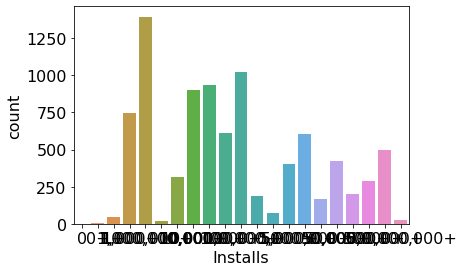

In [207]:
sns.countplot(x='Installs', data=df)  # Basic Count Plot of our Install Metric

As we can see, the installs variable may need to be cleaned up.  Since this is a categorical variable 
based of numerics, they have a natural order. 

Since the data does not seem to be standardized, we may need to create a dictionary to save the correct order from 
checking the original data.  We know there are 21 categories, so it is not too hard to order.  


In [208]:
# Ordered list of installs
inst = ['0','0+','1+','5+','10+','50+','100+','500+','1,000+','5,000+','10,000+','50,000+','100,000+','500,000+',
        '1,000,000+','5,000,000+','10,000,000+','50,000,000+','100,000,000+','500,000,000+','1,000,000,000+']

installs = {}  # Init a Dict to hold order and count
for i, cat in enumerate(inst): # Loop through list
    installs[cat] = [i, 0]  # establish the keys and values (order) and an empty count
    
installs

{'0': [0, 0],
 '0+': [1, 0],
 '1+': [2, 0],
 '5+': [3, 0],
 '10+': [4, 0],
 '50+': [5, 0],
 '100+': [6, 0],
 '500+': [7, 0],
 '1,000+': [8, 0],
 '5,000+': [9, 0],
 '10,000+': [10, 0],
 '50,000+': [11, 0],
 '100,000+': [12, 0],
 '500,000+': [13, 0],
 '1,000,000+': [14, 0],
 '5,000,000+': [15, 0],
 '10,000,000+': [16, 0],
 '50,000,000+': [17, 0],
 '100,000,000+': [18, 0],
 '500,000,000+': [19, 0],
 '1,000,000,000+': [20, 0]}

Now we have a dictionary of install categories and it is ordered by size.  We will now add a second value to each key 
with their counts from the dataset.  This should serve as a better visual for us to make our labels from.

In [209]:
for i in df.Installs:
    installs[i][1] += 1  # for each key we come accross imcriment the count value by one
    
installs  # Preview installs

{'0': [0, 1],
 '0+': [1, 4],
 '1+': [2, 45],
 '5+': [3, 70],
 '10+': [4, 314],
 '50+': [5, 170],
 '100+': [6, 613],
 '500+': [7, 288],
 '1,000+': [8, 744],
 '5,000+': [9, 400],
 '10,000+': [10, 904],
 '50,000+': [11, 423],
 '100,000+': [12, 1024],
 '500,000+': [13, 494],
 '1,000,000+': [14, 1395],
 '5,000,000+': [15, 606],
 '10,000,000+': [16, 932],
 '50,000,000+': [17, 203],
 '100,000,000+': [18, 188],
 '500,000,000+': [19, 24],
 '1,000,000,000+': [20, 20]}

Now we can see the distribution of our install groups, too keep this simple we should maybe define our labels to 
be based off of a certain percentile of responses.  We know we have approx. 8,800 responses, so we can easily break 
this distribution into Quartiles (Approx. 2,200 responses per quartile).  We are okay with rough estimates here as 
we are just investigating the current market.  We need some way to define a 'true' label, so we start with basic and 
see our results. 

1,000+ & Below: 2249 Responses (25.4 perc)
5,000+ - 100,000+: 2751 Responses (56.4 perc)
500,000+ - 5,000,000+: 2495 Responses (84.6 perc)
10,000,000+ - 1,000,000,000+: 1367 Responses (100 perc)

As you can see this does not work out well, but we can now have a starting point at least.  If we start the label of 
success at anything 10,000,000+ or above, we now know we are grabbing the top 15.4% of apps as far as installs go.

In [210]:
succ_group = [k for k, v in installs.items() if v[0]>=16]  # Create binary label for any install category with index 16+

df['label'] = df.Installs.isin(succ_group)  # Attach labels to the dataframe
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,...,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,ContentRating_Adults only 18+,ContentRating_Everyone,ContentRating_Everyone 10+,ContentRating_Mature 17+,ContentRating_Teen,ContentRating_Unrated,label
2989,GollerCepte Live Score,SPORTS,4.2,9992,31M,"1,000,000+",Free,0,Everyone,Sports,...,0,0,0,0,1,0,0,0,0,False
4970,Ad Block REMOVER - NEED ROOT,TOOLS,3.3,999,91k,"100,000+",Free,0,Everyone,Tools,...,0,0,0,0,1,0,0,0,0,False
2723,SnipSnap Coupon App,SHOPPING,4.2,9975,18M,"1,000,000+",Free,0,Everyone,Shopping,...,0,0,0,0,1,0,0,0,0,False
3079,US Open Tennis Championships 2018,SPORTS,4.0,9971,33M,"1,000,000+",Free,0,Everyone,Sports,...,0,0,0,0,1,0,0,0,0,False
3229,DreamTrips,TRAVEL_AND_LOCAL,4.7,9971,22M,"500,000+",Free,0,Teen,Travel & Local,...,1,0,0,0,0,0,0,1,0,False


## Analyzing our Data
Now, lets look at the labels for success that we defined and see if we can gain any insight into what type of apps meet 
our criteria.

In [211]:
cat_inst = df[['Category','label']].groupby('Category').agg(['mean', 'count'])
cat_inst.sort_values(('label', 'mean'), ascending=False)[:5]

label      
                   mean count
Category                     
PHOTOGRAPHY    0.371648   261
ENTERTAINMENT  0.345238    84
GAME           0.334109   859
VIDEO_PLAYERS  0.283019   159
COMMUNICATION  0.268293   287

As we can see from a basic average of our labels the top 5 app Categories are:
- Photography
- Entertainment
- Game
- Video Players
- Communication

This is showing that our top categories have a "success" rate of approx. 27 - 37%
It is also to note the sizes of each group.  While they are not our largest categories I believe they 
are of sufficient size for this analysis.

Now we will move onto doing this same process for some of our other features

In [212]:
cr_inst = df[['Content Rating','label']].groupby('Content Rating').agg(['mean', 'count'])
cr_inst.sort_values(('label', 'mean'), ascending=False)[:5]

label      
                     mean count
Content Rating                 
Everyone 10+     0.258621   290
Teen             0.225510   980
Mature 17+       0.180593   371
Everyone         0.139135  7216
Adults only 18+  0.000000     3

Of interest it seems that games rated for young kids (teens) appear to have the highest chance of success.
Though due to the unbalanced sample sizes it may only be fair to say that having a rating outside of 
'Everyone' is the best practice.  Due to this I would suggest some level of mature content appropriate for 
young teens.

In [213]:
sc_inst = df[['Size_Class','label']].groupby('Size_Class').agg(['mean', 'count'])
sc_inst.sort_values(('label', 'mean'), ascending=False)

label      
                mean count
Size_Class                
1           0.438961  1155
8           0.306122   392
7           0.267025   558
6           0.163907   604
5           0.137643   959

We can see clearly there are two things going on here. The smallest Apps (Category 1) appear to be very 
successful at being installed.  It seems likely that these are utility apps, meant to accomplish one small 
goal.  After that there is a clear pattern that the larger Apps appear to be the most successful.

So my take away here is that there are probably two types of successful app strategies, create a utility app 
that provides small amounts of functionality OR build an large app that provides a very large experience.



Now it is time to trim off the unnecessary columns from our data set so that we can convert our df into valid arrays 
for our model.




Story:
- Look at market to find frequencies of below metrics
- Now Look at Installs by Category, Rating, Genres, Content Rating to find the most successful groups




In [214]:
remove = ['App', 'Category', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated',
          'Current Ver', 'Android Ver', 'Reviews']

df.drop(remove, axis=1, inplace=True)
df.head()

,Rating,Size_Conv,Size_Class,Genre_Action,Genre_Action & Adventure,Genre_Adventure,Genre_Arcade,Genre_Art & Design,Genre_Auto & Vehicles,Genre_Beauty,...,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,ContentRating_Adults only 18+,ContentRating_Everyone,ContentRating_Everyone 10+,ContentRating_Mature 17+,ContentRating_Teen,ContentRating_Unrated,label
2989,4.2,31000.0,5,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
4970,3.3,91.0,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
2723,4.2,18000.0,4,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
3079,4.0,33000.0,5,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
3229,4.7,22000.0,4,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,False


Now we can build a single decision tree to start 

In [215]:
RSEED=500

# Create our Labels
labels = np.array(df.pop('label'))

# Split our data by 80/20 rule
train, test, train_labels, test_labels = train_test_split(df, labels, stratify=labels, test_size=0.20, random_state=RSEED)

# Impute ratings column for missing values
train.Rating = train.Rating.fillna(train.Rating.mean())
test.Rating = test.Rating.fillna(test.Rating.mean())

# Features for feature importances
features = list(train.columns)

c:\users\hanes\ideaprojects\venv\dataquest64\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [216]:
train.shape

(7089, 95)

In [217]:
test.shape


(1773, 95)

In [218]:
# train the tree
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')


Decision tree has 2661 nodes with maximum depth 45.


In [219]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)


In [220]:
print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 0.9973363695828181
Test ROC AUC  Score: 0.6921294261294261


In [221]:
"""Compare machine learning model to baseline performance.
Computes statistics and shows ROC curve."""
def evaluate_model(predictions, probs, train_predictions, train_probs):
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)
    
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend()
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [222]:
print(Counter(probs))
print(Counter(predictions))


Counter({0.0: 1461, 1.0: 236, 0.5: 20, 0.6666666666666666: 10, 0.8: 8, 0.3333333333333333: 5, 0.25: 5, 0.7142857142857143: 4, 0.375: 4, 0.16666666666666666: 3, 0.45454545454545453: 3, 0.8461538461538461: 2, 0.5714285714285714: 2, 0.2: 2, 0.5555555555555556: 2, 0.7777777777777778: 2, 0.4444444444444444: 2, 0.8333333333333334: 1, 0.75: 1})
Counter({False: 1505, True: 268})


Recall Baseline: 1.0 Test: 0.44 Train: 0.88
Precision Baseline: 0.15 Test: 0.45 Train: 0.96
Roc Baseline: 0.5 Test: 0.69 Train: 1.0


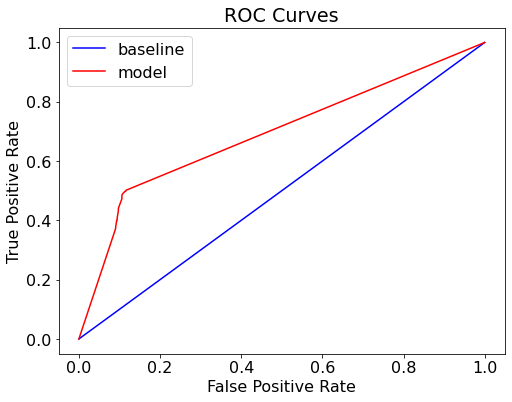

In [223]:
evaluate_model(predictions, probs, train_predictions, train_probs)

In [224]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
    return cm[1, 1], cm[0,0], cm[0, 1], cm[1, 0]

Confusion matrix, without normalization
[[1353  147]
 [ 152  121]]
Overall, how often the model is incorrect. 
 Classification Error:  0.16864072194021432


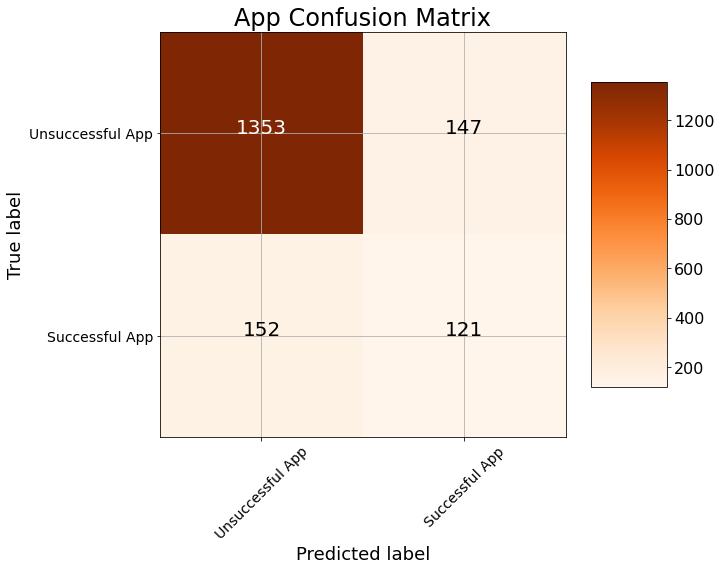

In [225]:
cm = confusion_matrix(test_labels, predictions)
TP, TN, FP, FN = plot_confusion_matrix(cm, classes = ['Unsuccessful App', 'Successful App'],
                      title = 'App Confusion Matrix')
print('Overall, how often the model is incorrect.',os.linesep, 'Classification Error: ', ((FP + FN)/float(TP + TN + FP + FN)))

In [226]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
1,Size_Conv,0.396757
0,Rating,0.236188
70,Category_GAME,0.034361
2,Size_Class,0.029588
90,ContentRating_Everyone,0.023224


In [227]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=500,
                       verbose=1)

In [228]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 2484
Average maximum depth 48


In [229]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 0.42 Train: 0.9
Precision Baseline: 0.15 Test: 0.51 Train: 0.93
Roc Baseline: 0.5 Test: 0.83 Train: 1.0


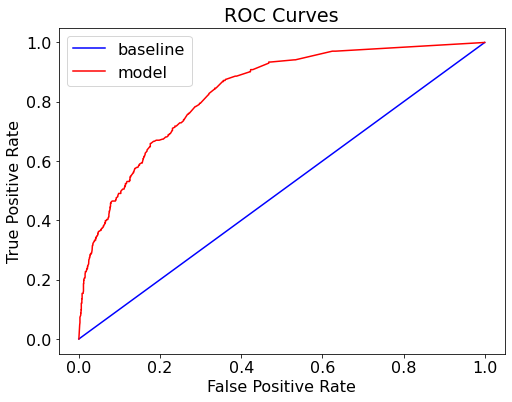

In [230]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[1389  111]
 [ 158  115]]
Overall, how often the model is incorrect. 
 Classification Error:  0.15172024816694868


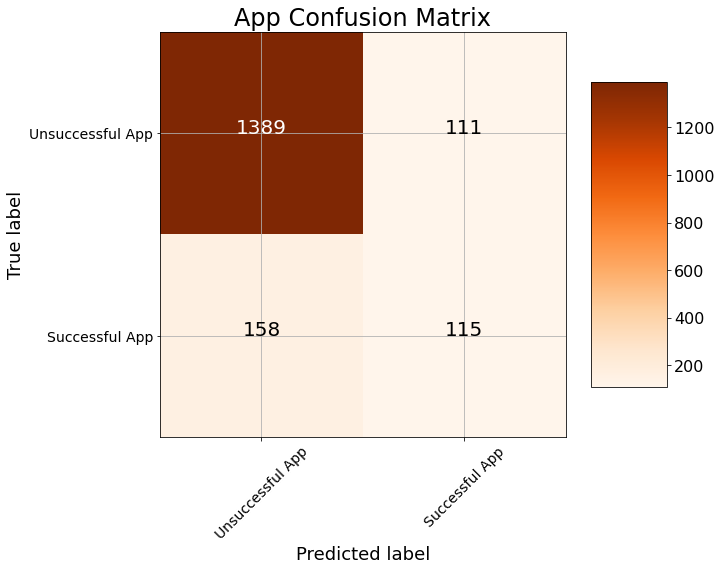

In [231]:

cm = confusion_matrix(test_labels, rf_predictions)
TP, TN, FP, FN = plot_confusion_matrix(cm, classes = ['Unsuccessful App', 'Successful App'],
                      title = 'App Confusion Matrix')
print('Overall, how often the model is incorrect.',os.linesep, 'Classification Error: ', ((FP + FN)/float(TP + TN + FP + FN)))


In [232]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)


,feature,importance
1,Size_Conv,0.318018
0,Rating,0.272622
2,Size_Class,0.119996
70,Category_GAME,0.017538
90,ContentRating_Everyone,0.013894
93,ContentRating_Teen,0.011350
6,Genre_Arcade,0.008322
16,Genre_Casual,0.007993
3,Genre_Action,0.007607
67,Category_FAMILY,0.007228


In [233]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=500),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                    

In [234]:
rs.best_params_


{'n_estimators': 29,
 'min_samples_split': 2,
 'max_leaf_nodes': 46,
 'max_features': 'auto',
 'max_depth': 15,
 'bootstrap': False}

In [235]:
best_model = rs.best_estimator_

In [236]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [237]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Average number of nodes 91
Average maximum depth 14


Recall Baseline: 1.0 Test: 0.2 Train: 0.17
Precision Baseline: 0.15 Test: 0.71 Train: 0.78
Roc Baseline: 0.5 Test: 0.85 Train: 0.85


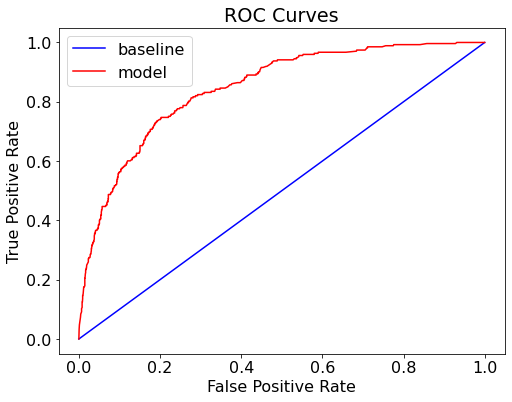

In [238]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[1478   22]
 [ 219   54]]
Overall, how often the model is incorrect. 
 Classification Error:  0.1359278059785674


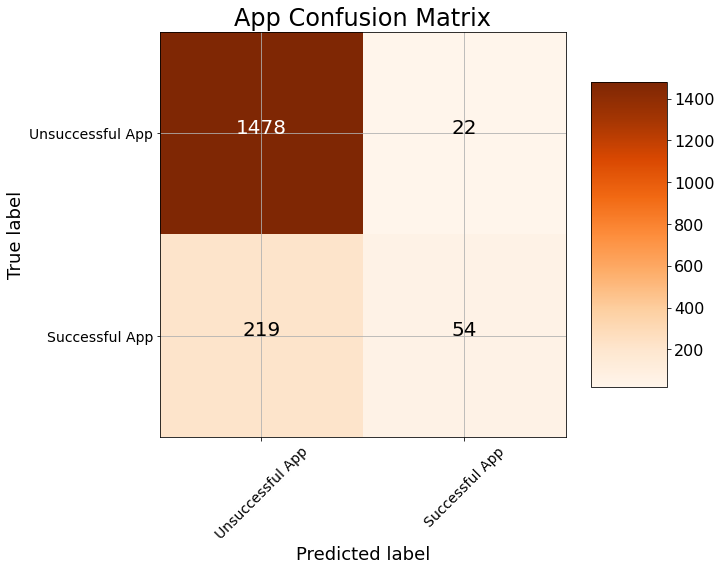

In [239]:
cm = confusion_matrix(test_labels, rf_predictions)
TP, TN, FP, FN = plot_confusion_matrix(cm, classes = ['Unsuccessful App', 'Successful App'],
                      title = 'App Confusion Matrix')
print('Overall, how often the model is incorrect.',os.linesep, 'Classification Error: ', ((FP + FN)/float(TP + TN + FP + FN)))


In [240]:
fpr, tpr, thresholds = roc_curve(test_labels, rf_probs)

def evaluate_thresh(threshold):
    print('Recall: ', round(tpr[thresholds > threshold][-1], 3))
    print('Precision: ', round(1 - fpr[thresholds > threshold][-1], 3))
    print(os.linesep)

for i in range(20, 80, 5):
    print('Threshold: ' + str(round(i * 0.01, 2)))
    evaluate_thresh(i*0.01)

Threshold: 0.2
Recall:  0.67
Precision:  0.839


Threshold: 0.25
Recall:  0.601
Precision:  0.878


Threshold: 0.3
Recall:  0.495
Precision:  0.921


Threshold: 0.35
Recall:  0.44
Precision:  0.943


Threshold: 0.4
Recall:  0.355
Precision:  0.96


Threshold: 0.45
Recall:  0.282
Precision:  0.972


Threshold: 0.5
Recall:  0.179
Precision:  0.985


Threshold: 0.55
Recall:  0.136
Precision:  0.991


Threshold: 0.6
Recall:  0.106
Precision:  0.992


Threshold: 0.65
Recall:  0.092
Precision:  0.993


Threshold: 0.7
Recall:  0.033
Precision:  0.999


Threshold: 0.75
Recall:  0.033
Precision:  0.999




Confusion matrix, without normalization
[[1488   12]
 [ 244   29]]
Overall, how often the model is incorrect. 
 Classification Error:  0.14438804286520024
Recall:  0.10622710622710622
Precision:  0.992


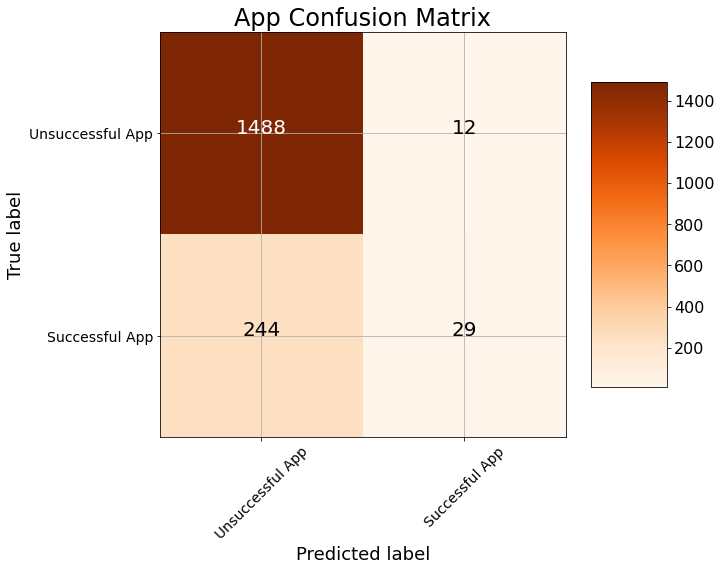

In [241]:
# Goal of 85% Precision
new_threshold = 0.6

y_pred_class = binarize(rf_probs.reshape(-1, 1), threshold=new_threshold)
cm = confusion_matrix(test_labels, y_pred_class)
TP, TN, FP, FN = plot_confusion_matrix(cm, classes = ['Unsuccessful App', 'Successful App'],
                      title = 'App Confusion Matrix')
print('Overall, how often the model is incorrect.', os.linesep, 'Classification Error: ', ((FP + FN)/float(TP + TN + FP + FN)))
print('Recall: ', TP / (FN + TP))
print('Precision: ', TN / (TN + FP))

